In [1]:
import psycopg2

connection = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret',
)

In [2]:
import pandas as pd

cursor = connection.cursor()
cursor.execute(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE created_at >= CURRENT_DATE - INTERVAL '1 year'
    GROUP BY registration_day
    ORDER BY registration_day
    """
    )
dates_and_registrations = cursor.fetchall()
df = pd.DataFrame(dates_and_registrations, columns=['registration_day', 'num_registrations'])
df['registration_day'] = pd.to_datetime(df['registration_day'])
df_resampled = df.set_index('registration_day').resample('D').sum().fillna(value=0)

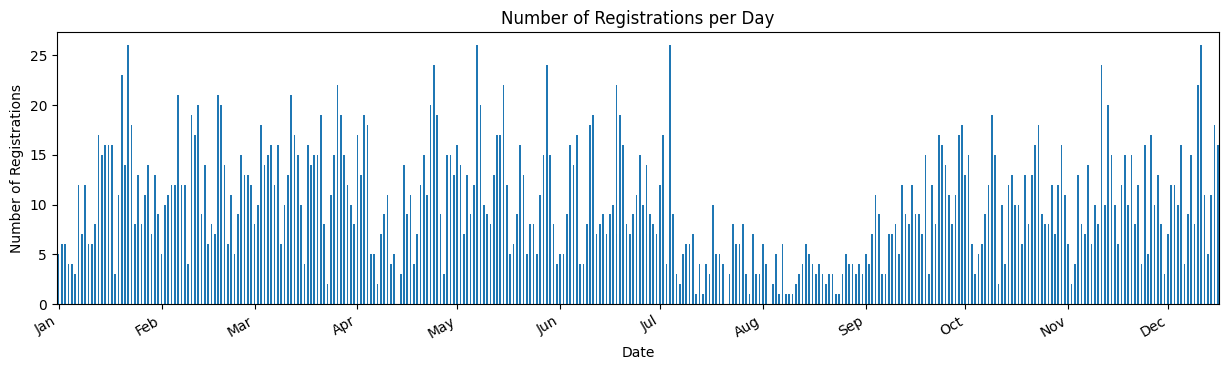

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 4))
df_resampled['num_registrations'].plot(kind='bar')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.title('Number of Registrations per Day')
plt.show()